In [1]:
from sys import platform as sys_pf
# if sys_pf == 'darwin':
#     import matplotlib
#     matplotlib.use("TkAgg")
! pip install simpleitk
%matplotlib inline  
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import SimpleITK as sitk
from scipy import ndimage
import random
import math

In [2]:
image_shape = (256,256,176)

# Read in transformed images
def read_file(filename):
    data = np.loadtxt(filename, delimiter=",")
    data = np.reshape(data,image_shape)
    return data

# Read in non-transformed images
def read_original(filename):
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(filename)
    image = reader.Execute()

    # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

    # convert image into np array & perform fft
    img = sitk.GetArrayFromImage(image)
    # Transpose the image so the first axis is Anterior-Posterior
    img = np.transpose(img, (2,1,0))
    return img 

def visualize(orig, new):
    plt.figure(figsize= (20,20))
    plt.subplot(121), plt.imshow(orig, cmap='gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(new, cmap='gray')
    plt.title('New'), plt.xticks([]), plt.yticks([])
    
def visualize3(orig, blur, predict):
    plt.figure(figsize= (30,30))
    plt.subplot(131), plt.imshow(orig, cmap='gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(blur, cmap='gray')
    plt.title('Blurred'), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(predict, cmap='gray')
    plt.title('Predicted'), plt.xticks([]), plt.yticks([])

In [4]:
new = read_file('transforms/M02_motion5_trans.txt.gz')
orig = read_original('mris/M02.nii')


(Text(0.5,1,'New'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

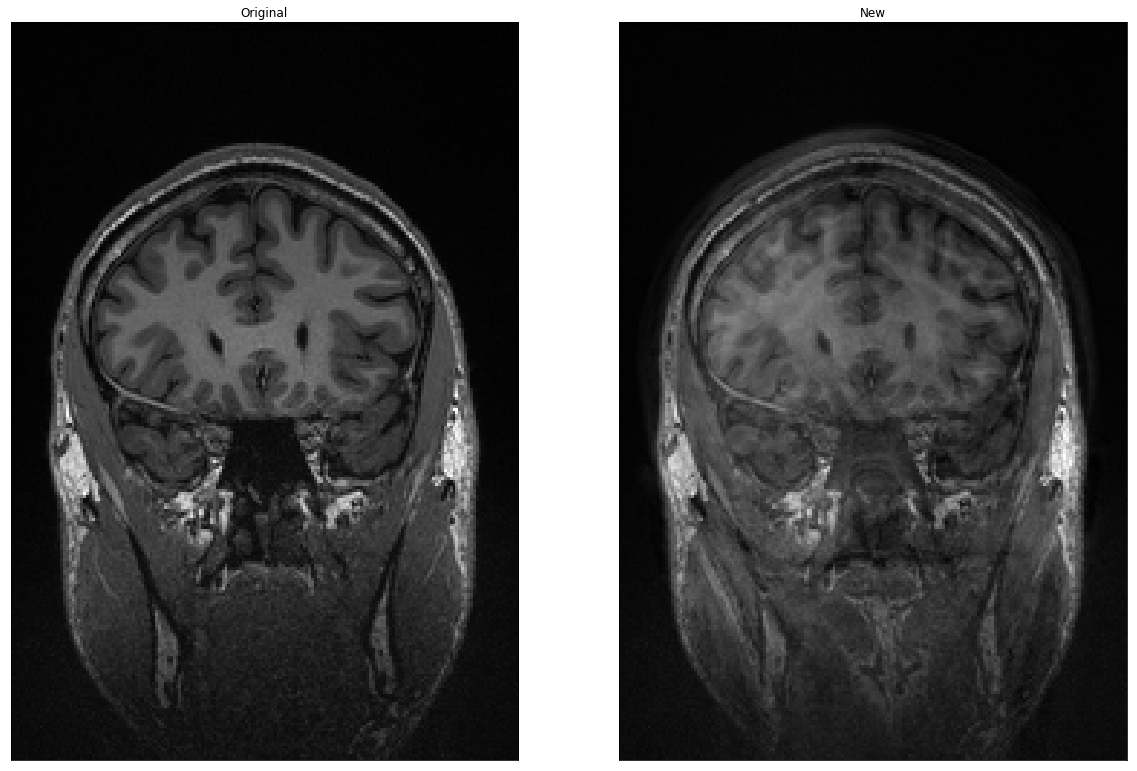

In [6]:
plt.figure(figsize= (20,20))
plt.subplot(121), plt.imshow(orig[100], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new[100], cmap='gray')
plt.title('New'), plt.xticks([]), plt.yticks([])

In [7]:
#   Preprocessing
# Data- Slice range from 70 to 220
# Flatten each image
# keras.utils.normalize each image
# reshape back

#   Architecture

# Input layer

# 2d convolution
# activation- relu
# 2d convlution
# activation- relu

# loss = mse


# TO DO-
# Double check the normalization function by multiplying output slice by max val & visualizing
# Put together full pipeline taking in all mris
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU, Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D
from tensorflow.keras import backend as K
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizers
from sklearn import preprocessing as prepro

/Users/eggfooyang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
def generate_data(t_filenames, o_filenames, min_slc = 10, max_slc = 166):
    # Takes in the files of the transformed images and the originals to create the pairs
    # Also sets the min and max slice numbers to take in
    x_data = []
    y_data = []
    for i in range(len(t_filenames)):
        print('Generating data for: ' + t_filenames[i])
        x_mri = read_file(t_filenames[i])
        y_mri = read_original(o_filenames[i])
        
        # Tranpose the images to left-right slices instead of anterior-posterior
        x_mri = np.transpose(x_mri, (2,1,0))
        y_mri = np.transpose(y_mri, (2,1,0))
        for ii in np.arange(min_slc, max_slc+1):
            x_data.append(x_mri[ii])
            y_data.append(y_mri[ii])
    # Shape of x & y will be [# slices, 256, 176]
#     x_data = norm_slices(x_data)
#     y_data = norm_slices(y_data)
    return x_data, y_data

# Normalizes each image slice
def norm_slices (data):    
    orig_shape = np.shape(data)
    new_shape = np.reshape(data, (list(orig_shape)[0], list(orig_shape)[1] * list(orig_shape)[2]))
    new_shape_norm = tf.keras.utils.normalize(new_shape, axis=0, order=2)
    return np.reshape(new_shape_norm, orig_shape)

In [9]:
trans_folder = 'transforms/'
orig_folder = 'mris/'
X_filenames = []
y_filenames = []
for item in os.listdir(trans_folder):
    if item.endswith("_trans.txt.gz"):
        X_filenames.append(trans_folder + item)
        y_filenames.append(orig_folder + item[:3] + '.nii')

# X, y = generate_data(['gdrive/My Drive/NU_Rad/transforms/M02_motion5_trans.txt.gz'], ['gdrive/My Drive/NU_Rad/mris/M02.nii'])
X, y = generate_data(X_filenames, y_filenames)

Generating data for: transforms/M02_motion3_trans.txt.gz
Generating data for: transforms/M02_motion4_trans.txt.gz
Generating data for: transforms/M01_motion1_trans.txt.gz
Generating data for: transforms/M02_motion5_trans.txt.gz
Generating data for: transforms/M02_motion2_trans.txt.gz
Generating data for: transforms/M05_motion1_trans.txt.gz
Generating data for: transforms/M06_motion3_trans.txt.gz
Generating data for: transforms/M06_motion4_trans.txt.gz
Generating data for: transforms/M03_motion4_trans.txt.gz
Generating data for: transforms/M03_motion3_trans.txt.gz
Generating data for: transforms/M03_motion2_trans.txt.gz
Generating data for: transforms/M03_motion5_trans.txt.gz
Generating data for: transforms/M06_motion5_trans.txt.gz
Generating data for: transforms/M06_motion2_trans.txt.gz
Generating data for: transforms/M05_motion5_trans.txt.gz
Generating data for: transforms/M05_motion3_trans.txt.gz
Generating data for: transforms/M05_motion4_trans.txt.gz
Generating data for: transforms

In [11]:
X = np.reshape(X, (3611, 256, 256, 1))
y = np.reshape(y, (3611, 256, 256))
model = Sequential()
model.add(Conv2D(128, (5,5), padding='same', input_shape = X.shape[1:]))
model.add(Activation("relu"))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation("relu"))

model.add(Dense(128))
model.add(Dense(1))
model.add(Reshape((256,256)))

model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
model.fit(X, y, batch_size=10, validation_split=0.1, epochs = 1)

Train on 3249 samples, validate on 362 samples
Epoch 1/1
1310/3249 [===========>..................] - ETA: 3:48:19 - loss: 2169.8928 - acc: 0.3415

KeyboardInterrupt: 

In [ ]:
X_predict, y_predict = generate_data(['gdrive/My Drive/NU_Rad/transforms/M02_motion5_trans.txt.gz'], ['gdrive/My Drive/NU_Rad/mris/M02.nii'])

In [ ]:
predict_slice = 120
X_input = np.reshape(X_predict[predict_slice], (1, 256, 256, 1))
predict_out = model.predict(np.array(X_input))

output = np.reshape(predict_out, (256, 256))
# output = output*690
visualize3(y_predict[predict_slice], X_predict[predict_slice], output)